# Exercise 3
All previous instructions hold. In addition, if you are using GPU, you must check that your code also runs on a CPU. 

**Make sure you use the best practices you learned in class**.

In [76]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim

%matplotlib inline
plt.rcParams['figure.figsize'] = (12.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


# Convolutional Neural Network - Classifiying CIFAR-10 (40 points)

So far we had to manually implement both the forward and backward passes of our neural network. Manually implementing the backward pass is not a big deal for a small two-layer network, but can quickly get very messy for large complex networks.

Thankfully, we can use **automatic differentiation** to automate the computation of backward passes in neural networks. The autograd package in PyTorch provides exactly this functionality. When using autograd, the forward pass of your network will define a computational graph. Nodes in the graph will be Tensors,
and edges will be functions that produce output Tensors from input Tensors. Backpropagating through this graph then allows you to easily compute gradients.

If we want to compute gradients with respect to some Tensor, then we set `requires_grad=True` when constructing that Tensor. Any PyTorch operations on that Tensor will cause a computational graph to be constructed, allowing us to later perform backpropagation through the graph. If `x` is a Tensor with `requires_grad=True`, then after backpropagation `x.grad` will be another Tensor holding the gradient of `x`.

Sometimes you may wish to prevent PyTorch from building computational graphs when performing certain operations on Tensors with `requires_grad=True`; for example, we usually don't want to backpropagate through the weight update steps when evaluating a neural network. In such scenarios we can use the `torch.no_grad()` context manager to prevent the construction of a computational graph.

In this exercise, you will accomplish the following:
1. Train a convolutional network using PyTorch.
2. Evaluate your model using a confusion matrix.
3. Solve the localization task using regression.

### Data Preprocessing

In [77]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Image shape:  torch.Size([3, 32, 32])
     truck       frog      truck      horse


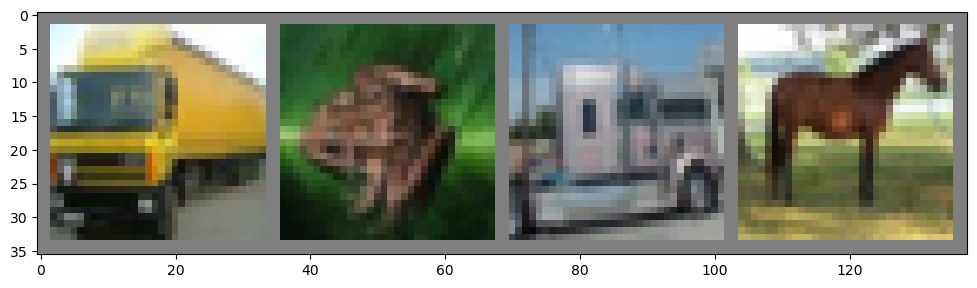

In [78]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0))) # plt accepts images in the format (w,h,c)
    
# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter) # dataiter.next()

print("Image shape: ", images[0].shape)
# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join('%10s' % classes[labels[j]] for j in range(4)))

### Construct a CNN in PyTorch

In the following class, initiate your different layers in the `__init__` method and define your architecture in the `forward` method. Make sure the `forward` method has a single return value. 

1. Make good use of the documentation and experiment will different layers, activations and architectures, batch sizes, regularization, filter sizes, dimensions, number of layers and whatever you learned in class. 
2. Use your intuition from the previous exercises and additional sources such as the stackoverflow, Medium, etc. - **do not try to perform a massive grid search.**
3. **Include only your chosen architecture**. During experimentation, you may add as many cells as you need. Make sure to delete them before submission.
4. It is not allowed to use famous models that have been already implemented by PyTorch (resnet, densenet, alexnet, etc).
5. Make sure your code runs reasonably fast (no more than 15 minutes on CPU).
6. Use the best architecture you find and train it for 1-10 epochs. 
7. Visualize the loss and accuracy of your network during training. You can use matplotlib.
8. You should get above 60% accuracy on the test set.
**(20 points)**

In [79]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #############################################################################
        # TO DO:                                                                    #
        # Initiate the different layers you wish to use in your network.            #
        # This method has no return value.                                          #
        #############################################################################
        """
        Initializes the CNN and its layers.
        """
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(in_features=64 * 4 * 4, out_features=512)
        self.fc2 = nn.Linear(in_features=512, out_features=10)
        self.logSoftMax = nn.LogSoftmax(dim = 1)
        self.relu = nn.ReLU()
        pass
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################
        
    def forward(self, x):
        #############################################################################
        # TO DO:                                                                    #
        # Define the forward propagation. You need to pass an image through the     #
        # network and obtain class predictions.                                     #
        # This function returns the predication of your model.                      #
        #############################################################################
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(-1, 64 * 4 * 4)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.logSoftMax(x)
        return x
        pass
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################

# Check if a GPU is available and set the device accordingly
device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = Net().to(device = device)
criterion = None
optimizer = None
#############################################################################
# TO DO:                                                                    #
# Define the loss function and optimizer.                                   # 
#############################################################################
# Cross entropy loss function
criterion = nn.CrossEntropyLoss()

# Adam optimizer, similar to SGD but uses an adaptive learning rate and adaptive gradient scaling technique
optimizer = optim.Adam(net.parameters(), lr=1e-3)

pass
#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

In [80]:
#############################################################################
# TO DO:                                                                    #
# Define the training loop as seen in class and as demonstrated in the      #
# documentation. Note, if you are using GPU, make sure your code runs on    #
# CPU also. Code that cannot run will not be tested.                        # 
#############################################################################

# Define the number of epochs
num_epochs = 10

# Check if a GPU is available and set the device accordingly
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Initialize lists to store the train/test losses and accuracies
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

# Train the model
for epoch in range(num_epochs):
    # Training loop
    net.train()
    train_loss = 0
    train_correct = 0
    for images, labels in trainloader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = net(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        _, pred = outputs.max(1)
        train_correct += pred.eq(labels).sum().item()


    # Append the train/test losses and accuracy to the lists
    train_losses.append(train_loss / len(trainloader))
    train_accuracies.append(train_correct / len(trainset))

    # Print the loss and accuracy for each epoch
    print(f'Epoch {epoch+1}: train loss = {train_losses[-1]:.4f}, train accuracy = {train_accuracies[-1]:.4f}')

pass
#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

Epoch 1: train loss = 1.4474, train accuracy = 0.4717
Epoch 2: train loss = 1.0394, train accuracy = 0.6315
Epoch 3: train loss = 0.8574, train accuracy = 0.6981
Epoch 4: train loss = 0.7350, train accuracy = 0.7414
Epoch 5: train loss = 0.6363, train accuracy = 0.7765
Epoch 6: train loss = 0.5515, train accuracy = 0.8058
Epoch 7: train loss = 0.4718, train accuracy = 0.8342
Epoch 8: train loss = 0.3889, train accuracy = 0.8626
Epoch 9: train loss = 0.3218, train accuracy = 0.8867
Epoch 10: train loss = 0.2619, train accuracy = 0.9069


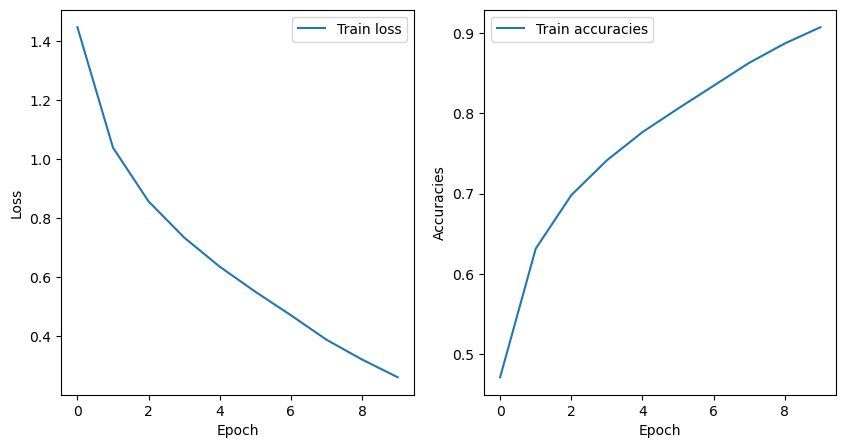

In [81]:
import matplotlib.pyplot as plt

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# Plot the train losses in the first subplot
ax1.plot(train_losses, label='Train loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot the train accuracies in the second subplot
ax2.plot(train_accuracies, label='Train accuracies')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracies')
ax2.legend()

# Show the plots
plt.show()


## Model evaluation

Calculate the model accuracy and print a confusion matrix where in y axis represents the real category and the x axis represents the predicted category. **(10 points)** 

In [82]:
confusion_matrix = np.zeros([10,10], int)
model_accuracy = 0
#############################################################################
# TO DO:                                                                    #
# Define the evaluation loop as seen in class and as demonstrated in the    #
# documentation and use the confusion matrix to evaluate your model.        # 
#############################################################################
import numpy as np
import sklearn.metrics

# Set the model to evaluation mode
net.eval()

# Initialize lists to store the predictions and labels
predictions = []
labels = []

# Loop over the test data
with torch.no_grad():
    for images, target in testloader:
        # Move the data to the device
        images = images.to(device)
        target = target.to(device)

        # Make predictions
        output = net(images)
        _, pred = output.max(1)

        # Append the predictions and labels to the lists
        predictions.append(pred.cpu().numpy())
        labels.append(target.cpu().numpy())

# Flatten the lists
predictions = np.concatenate(predictions)
labels = np.concatenate(labels)

# Calculate the accuracy
model_accuracy = (predictions == labels).mean() * 100
#print(f'Model accuracy: {accuracy:.3f}')

# Compute the confusion matrix
confusion_matrix = sklearn.metrics.confusion_matrix(labels, predictions)
#print(confusion_matrix)

pass
#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################
print('Model accuracy on {0} test images: {1:.2f}%'.format(len(testset), model_accuracy))

Model accuracy on 10000 test images: 73.37%


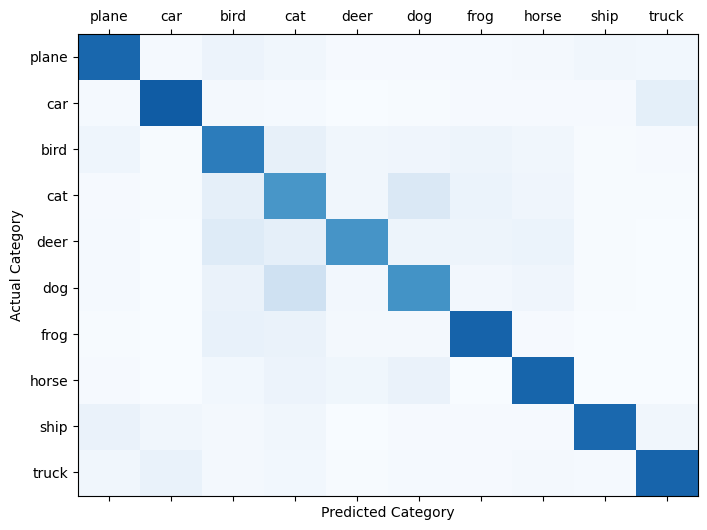

In [83]:
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.matshow(confusion_matrix, aspect='auto', vmin=0, vmax=1000, cmap=plt.get_cmap('Blues'))
plt.ylabel('Actual Category')
plt.yticks(range(10), classes)
plt.xlabel('Predicted Category')
plt.xticks(range(10), classes)
plt.show()

##**Question:** 
Describe your experiments.
What parameters have you experimented with? What works and what doesn't? Why?   **(5 Points)**

**Your answer:** In my experiments, I initially used the SGD optimizer, but I found that the model was learning too slowly. To try to improve the performance, I experimented with different values for the learning rate and momentum. While this helped to some extent, the model's performance was still not satisfactory.

I then decided to try using the Adam optimizer, which combines the benefits of both adaptive learning rate and adaptive gradient scaling technique. I found that Adam performed very well, and the model was able to learn much more efficiently compared to SGD in this case.

In terms of the architecture, I chose to use 3 convolutional layers followed by ReLU activation and max pooling, followed by 2 fully connected layers finished with softmax. This architecture allowed me to capture the important features in the data, and it performed well on the classification task. Overall, I found that using Adam and this particular architecture allowed me to achieve good performance and fast convergence on my problem.

i will note that it seems that my model has overfitting, and could be improved.

##**Question:** 
What can you learn from the confusion matrix? Why do you need additional evaluation methods other than accuracy? **(5 Points)**

**Your answer:**
*Here are some things that you can learn from a confusion matrix for the given classes:

- Whether the classifier is able to correctly predict all classes, or if it has difficulty with certain classes.
- Whether the classifier tends to confuse certain classes (i.e. predict one class when the true class is another).
- The relative size of the classes in the dataset (since the confusion matrix will have more entries for classes that have more samples)

Accuracy is a useful evaluation metric, but it can be misleading if the classes in the dataset are imbalanced (i.e. there are significantly more samples of one class than another). In this case, even a classifier that simply predicts the most common class all the time can achieve high accuracy.

To get a more complete picture of the classifier's performance, it is useful to use additional evaluation methods such as precision,recall, and the F1 score.

Using these additional evaluation metrics can give you a better understanding of how well the classifier is able to identify positive samples and avoid false positives. This is especially important if the classes are imbalanced or if you are particularly interested in identifying positive samples
 *

# Localization as Regression (60 points)

In the next part, we will use a well known architecture called ResNet18 that was trained on ImageNet, a dataset far more rich than CIFAR10. ImageNet has 1,000 classes and 1,000,000 images. In this part, we will use the features extracted from ResNet18 to localize and classify images of cats and dogs. 

Using a pretrained network as a building block for a more complicated task is at the heart of neural networks today. By leveraging the features ResNet18 extracts, we can train a model that can correctly classify and localize cats and dogs using very few images. 

In [84]:
import torchvision.transforms as transforms
from data.dataloader import *
from torchvision.models import resnet18, ResNet18_Weights
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torchvision.models as models
import torch.nn as nn
from PIL import Image
import collections
import time
import copy
import sys
import os


To load ResNet18 with the pretrained weights, use the following line. You are welcome to try different architectures, however they might require different input sizes or normalization.

The first time you run this cell the weights will be downloaded.

In [85]:
resnet18 = resnet18(weights=ResNet18_Weights.DEFAULT)

ResNet takes as input images of size (224,224). We will use PyTorch Transforms to change the size of the images. When ResNet18 was trained on ImageNet, the images were normalized using the mean and standard deviation of the images. In order to properly use the weights, we will use the same normalization.

In [86]:
data_transforms = {
    'train': transforms.Compose([
        Rescale((224,224)),
        ToTensor(),
        Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalizing according to imagenet
    ]),
    'val': transforms.Compose([
        Rescale((224,224)),
        ToTensor(),
        Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
root_dir = "data/animals/"
datasets = {x: VOCDetection(root_dir, image_set=x, transform=data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(datasets[x], batch_size=32, shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(datasets[x]) for x in ['train', 'val']}
classes = datasets['train'].classes
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [87]:
# Get a batch of training data
sample = next(iter(dataloaders['train']))

<Figure size 1200x800 with 0 Axes>

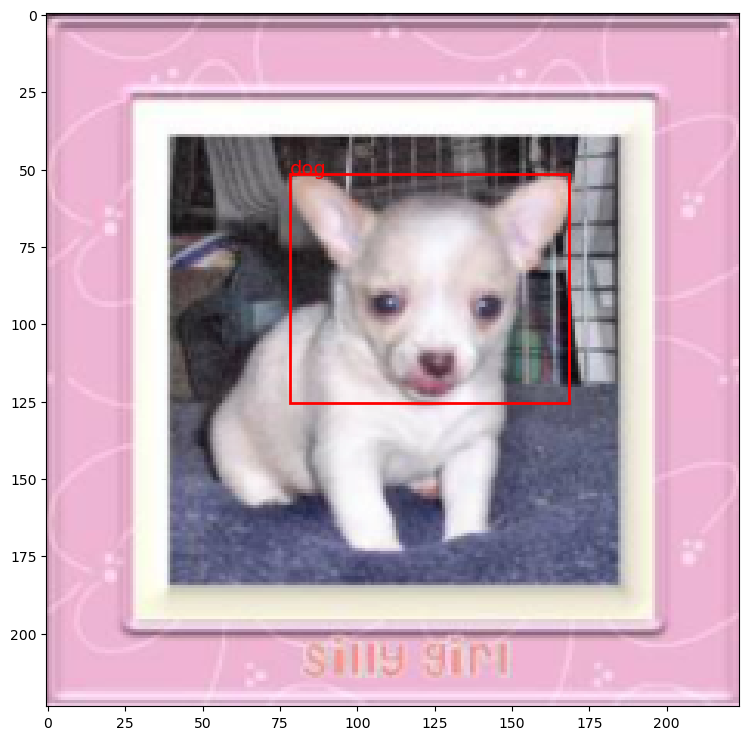

In [88]:
def imshow(img, label, bbox):
    image = np.copy(img[0])
    image = np.transpose(image, (1, 2, 0))
    image *= np.array([0.229, 0.224, 0.225])
    image += np.array([0.485, 0.456, 0.406])
    label = label[0]
    bbox = bbox[0]
    plt.figure();
    fig, ax = plt.subplots(1, figsize=(12,9));
    ax.imshow(image);
    x1, y1, x2, y2 = bbox.numpy().reshape(-1) * 224
    box_w, box_h = np.abs(x2-x1), np.abs(y2-y1)
    bbox = patches.Rectangle((x1, y1), box_w, box_h, linewidth=2, 
                             edgecolor='r', facecolor='none');
    ax.add_patch(bbox);
    ax.annotate(classes[label], (x1, y1), color='r', fontsize=14);

imshow(sample['image'],sample['label'],sample['bbox'])

In [89]:
from collections import OrderedDict


class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        #############################################################################
        # TO DO:                                                                    #
        # Load the pretrained ResNet-18 network and replace the top fully connected #
        # layer, so we could use the features of the network and not the only      #
        # the classification layer which carries significantly less information.    #
        # Afterwards, create a new sequential model with the remaining layers of    #
        # the pretrained network. Next, define two additional models that take as   #
        # input the extracted features and output the class scores and bounding box #
        # coordinates.                                                              #
        # This function has no return value.                                        #
        #############################################################################

        self.resnet = resnet18

        # Freeze the weights of the pre-trained ResNet-18 model
        for param in self.resnet.parameters():
            param.requires_grad = False

        # Replace the top fc layer with a new layer with the specified number of output classes
        fc_in_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(fc_in_features, fc_in_features)

        # Define the class scores model
        self.class_scores = nn.Linear(fc_in_features, num_classes)

        # Define the bounding box coordinates model, 4 output dimensions for the
        # bounding box coordinates (x, y, w, h)
        #self.bbox_coords = nn.Linear(fc_in_features, 4)
        self.bbox_coords = nn.Sequential(OrderedDict([
                             ('fc1', nn.Linear(fc_in_features, fc_in_features//2)),
                             ('relu1', nn.ReLU()),
                             ('fc2', nn.Linear(fc_in_features//2, fc_in_features//4)),
                             ('relu2', nn.ReLU()),
                             ('fc3', nn.Linear(fc_in_features//4, 4))
                           ]))
        # Define val/train loss/acc/iou history
        self.train_loss_history = []
        self.train_accuracy_history = []
        self.train_iou_history = []
        self.val_loss_history = []
        self.val_accuracy_history = []
        self.val_iou_history = []
        pass
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################
    
    def forward(self, images):
        #############################################################################
        # TO DO:                                                                    #
        # Define the forward propagation. You need to pass an image through the     #
        # network and extract the feature vector. In this case, when using a        #
        # predefined network, you don't want to change it's weights.                #
        # The rest of the layers you defined should accepts gradients for them to   #
        # improve during training.                                                  #
        # This function returns a class predication and a bounding box coordinates. #
        #############################################################################
        # Pass the input images through the pre-trained ResNet-18 network
        features = self.resnet(images)
        # Predict the class scores using the class scores model
        class_scores = self.class_scores(features)
        # Predict the bounding box coordinates using the bounding box coordinates model
        bbox_coords = self.bbox_coords(features)
        return class_scores, bbox_coords
        pass
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################

## Guidelines

1. Complete the `train_model` function in the cell below. This function takes as input the model and additional hyper-parameters, and outputs the best model found on the validation set. 
2. To babysit the learning process, **you must track the classification accuracy, IoU score and loss on the training and validation datasets and visualize them** (using matplotlib or similar). I have included an implementation of the IoU metric in the file `data\dataloader.py`.
3. Do not perform a massive grid search. Use papers, blogs, MOOCs and online guides to research best hyper-parameters for your model.
4. You are encouraged to try Google Colab. If you have an CUDA capable GPU at home - you are welcome to use it.
5. **Include only your chosen architecture**. During experimentation, you may add as many cells as you need. Make sure to delete them before submission.
6. Training large neural networks may take a while. Make sure your code runs reasonably fast (~15 minutes on CPU and ~5 minutes on GPU).
7. Try to reach at least 90% classification accuracy and a IOU score of at least 0.60 on the validation set.
8. **In order to get full marks for this section explain the results and include visualizations.**.
9. You are given a general skeleton for the training function. Feel free to use any different structure.

In [90]:
def train_model(model, criterion_cls, criterion_bbox, optimizer, scheduler=None, num_epochs=5):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict()) # this is how a model is copied
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0   # total loss of the network at each epoch
            running_corrects = 0 # number of correct predictions
            iou = 0.0            # IoU score
            
            # Iterate over data.
            for sample in dataloaders[phase]:
                #############################################################################
                # TO DO:                                                                    #
                # Extract the data from the dataloader, calculate the predictions of your   #
                # network and calculate the loss of the classification and bounding box     #
                # prediction. When in training mode, back-prop and update the weights.      #
                # At each epoch, calculate the test and train accuracy and IoU.             #
                # This function returns the best model in terms of accuracy.                #
                #############################################################################
                # Extract the data from the dataloader
                images = sample['image']
                labels = sample['label']
                bboxes = sample['bbox']

                images = images.to(device)
                labels = labels.to(device)
                bboxes = bboxes.to(device)

                # Set the gradients to zero
                optimizer.zero_grad()

                # Set the model to train mode
                model.train()

                # Calculate the predictions of your network
                class_scores, bbox_coords = model(images)

                # Calculate the loss of the classification and bounding box prediction
                loss_cls = criterion_cls(class_scores, labels)
                loss_bbox = criterion_bbox(bbox_coords, bboxes)
                loss = 0.25* loss_cls + loss_bbox

                # Back-prop and update the weights
                loss.backward()
                optimizer.step()

                # Calculate the test and train accuracy and IoU
                _, preds = torch.max(class_scores, 1)
                running_corrects += torch.sum(preds == labels.data)
                # calculate the iou score for each pair boxes in bboxes using bb_intersection_over_union(boxA, boxB):
                for i in range(len(bboxes)):
                    iou += bb_intersection_over_union(bbox_coords[i], bboxes[i])
                # Update the total loss
                running_loss += loss.item() * images.size(0)
                pass
                #############################################################################
                #                             END OF YOUR CODE                              #
                #############################################################################

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            iou = iou.item() / dataset_sizes[phase]
            # add to history
            if phase == 'train':
                model.train_loss_history.append(epoch_loss)
                model.train_accuracy_history.append(epoch_acc.to("cpu"))
                model.train_iou_history.append(iou)
            else:
                model.val_loss_history.append(epoch_loss)
                model.val_accuracy_history.append(epoch_acc.to("cpu"))
                model.val_iou_history.append(iou)


            print('{} Loss: {:.4f}  |  Acc: {:.4f}  |  IOU: {:.4f}'.format(
                phase, epoch_loss, epoch_acc, iou))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

Choose your optimizer and the loss functions for the classification and bounding box regression.

In [91]:
import torch.optim as optim

cnn = CNN(2)
cnn = cnn.to(device)

criterion_cls = None
criterion_bbox = None
optimizer = None
#############################################################################
#                           START OF YOUR CODE                              #
#############################################################################
criterion_cls = nn.CrossEntropyLoss()
criterion_bbox = nn.MSELoss()
optimizer = optim.Adam(cnn.parameters(), lr=0.001)
pass
#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

In [95]:
best_model = train_model(cnn, criterion_cls, criterion_bbox, optimizer, num_epochs=10)

Epoch 1/10
----------
train Loss: 0.0196  |  Acc: 0.9921  |  IOU: 0.7701
val Loss: 0.0192  |  Acc: 0.9937  |  IOU: 0.7809
Epoch 2/10
----------
train Loss: 0.0211  |  Acc: 0.9906  |  IOU: 0.7788
val Loss: 0.0340  |  Acc: 0.9747  |  IOU: 0.7890
Epoch 3/10
----------
train Loss: 0.0266  |  Acc: 0.9811  |  IOU: 0.7805
val Loss: 0.0178  |  Acc: 0.9937  |  IOU: 0.7938
Epoch 4/10
----------
train Loss: 0.0161  |  Acc: 0.9937  |  IOU: 0.7866
val Loss: 0.0108  |  Acc: 1.0000  |  IOU: 0.8051
Epoch 5/10
----------
train Loss: 0.0303  |  Acc: 0.9717  |  IOU: 0.7864
val Loss: 0.0189  |  Acc: 0.9937  |  IOU: 0.7846
Epoch 6/10
----------
train Loss: 0.0195  |  Acc: 0.9921  |  IOU: 0.7778
val Loss: 0.0112  |  Acc: 1.0000  |  IOU: 0.8031
Epoch 7/10
----------
train Loss: 0.0184  |  Acc: 0.9890  |  IOU: 0.7818
val Loss: 0.0179  |  Acc: 0.9873  |  IOU: 0.7959
Epoch 8/10
----------
train Loss: 0.0165  |  Acc: 0.9953  |  IOU: 0.7862
val Loss: 0.0125  |  Acc: 1.0000  |  IOU: 0.7893
Epoch 9/10
----------
tr

Once you are pleased with your results, see how your model can predict and localize cats and dogs!

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 1200x800 with 0 Axes>

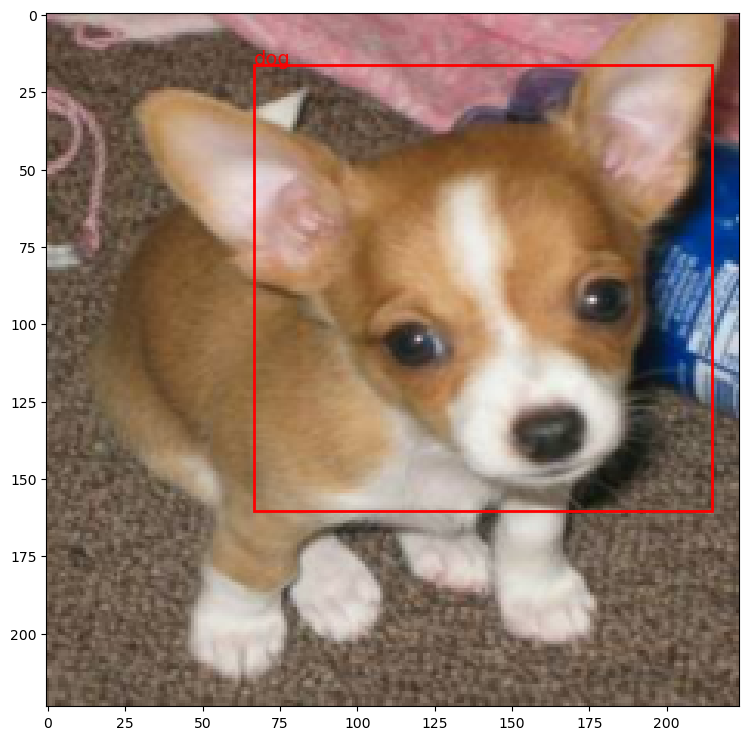

In [96]:
# Get a batch of validation data
sample = next(iter(dataloaders['val']))
with torch.no_grad():
    images = sample['image']
    images = images.to(device)
    label_pred, bbox_pred = best_model(images)
    _, label_pred = torch.max(label_pred, 1)
imshow(sample['image'], label_pred.cpu(), bbox_pred.cpu())

Your visualizations here (IoU / Accuracy / Loss on training and validation datasets as a function of the epoch). Only visualize the results of your best model.

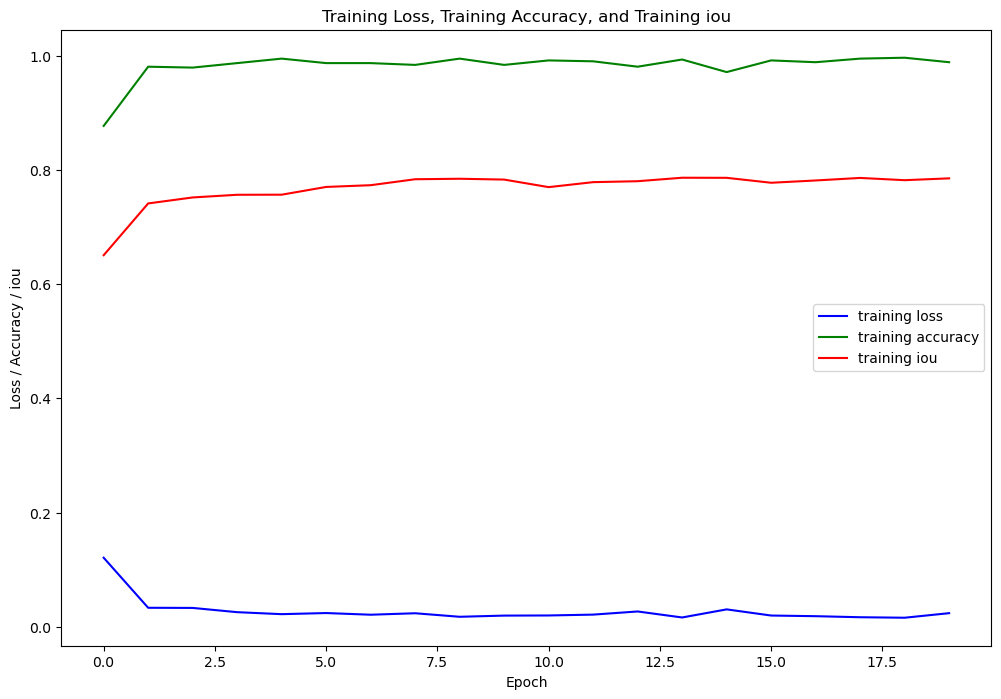

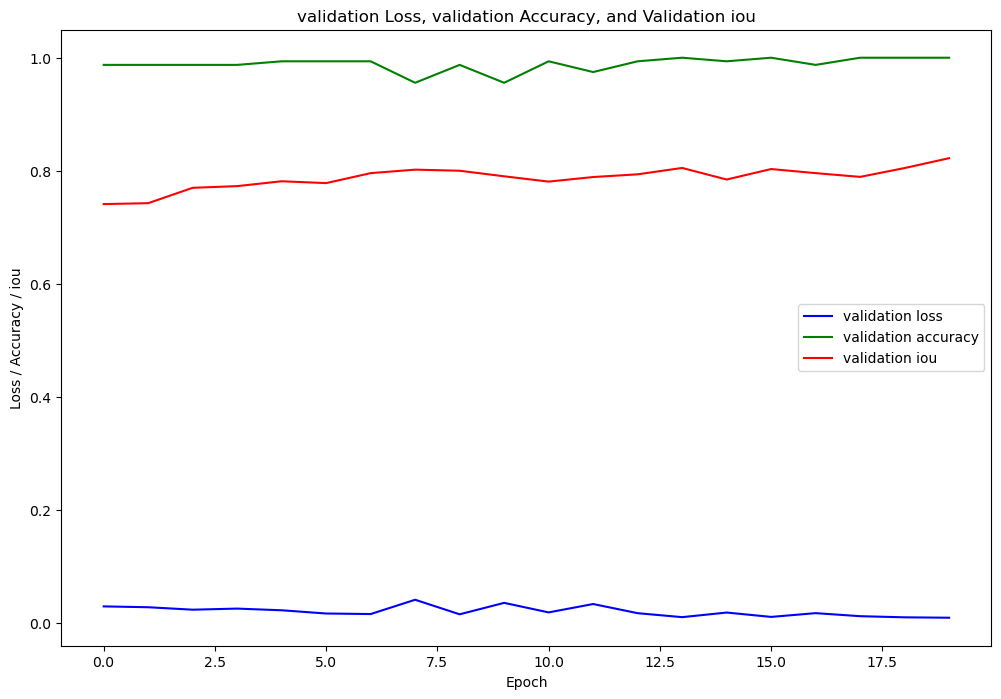

In [97]:
# plot best model iou/accuracy/loss history on training and validation.

import matplotlib.pyplot as plt

# Plot the training loss, training accuracy, and training iou on the same plot
plt.plot(best_model.train_loss_history, label='training loss', color='blue', linestyle='solid')
plt.plot(best_model.train_accuracy_history, label='training accuracy', color='green', linestyle='solid')
plt.plot(best_model.train_iou_history, label='training iou', color='red', linestyle='solid')

# Add a title, x-axis label, and y-axis label
plt.title('Training Loss, Training Accuracy, and Training iou')
plt.xlabel('Epoch')
plt.ylabel('Loss / Accuracy / iou')

# Add a legend and show the plot
plt.legend()
plt.show()

# Plot the validation loss, validation accuracy, and validation iou on the same plot
plt.plot(best_model.val_loss_history, label='validation loss', color='blue', linestyle='solid')
plt.plot(best_model.val_accuracy_history, label='validation accuracy', color='green', linestyle='solid')
plt.plot(best_model.val_iou_history, label='validation iou', color='red', linestyle='solid')

# Add a title, x-axis label, and y-axis label
plt.title('validation Loss, validation Accuracy, and Validation iou')
plt.xlabel('Epoch')
plt.ylabel('Loss / Accuracy / iou')

# Add a legend and show the plot
plt.legend()
plt.show()